In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nest

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


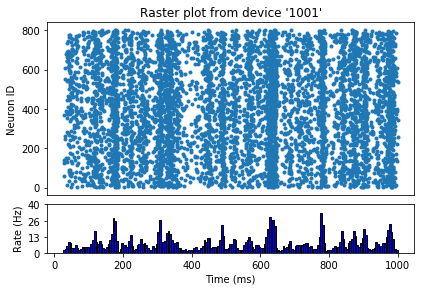

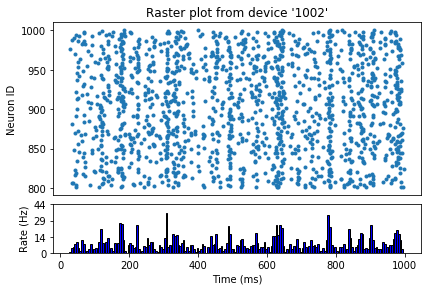

In [4]:
# SIMULATION PARAMETERS - 0D
dt = 0.1         # simulation time step size
tstop = 1000.    # simulation duration
NOISE_RATE = 6000.    # external rate
N_POPULAITONS = 2

# NETWORK PARAMETERS - 1D
N_NEURON_PP = [800, 200]              # number of neurons in each population
W_NOISE_MAX = [10, 10]                # max input weight of noise

# NETWORK PARAMETERS - 2D
CONN_PARAM   = [
    (0, 0, {'WMAX' : 10,  'PCONN' : 0.2}),
    (0, 1, {'WMAX' : 10,  'PCONN' : 0.2}),
    (1, 0, {'WMAX' : -40, 'PCONN' : 0.2}),
    (1, 1, {'WMAX' : -40, 'PCONN' : 0.2})
]

# reset kernel and set dt
nest.ResetKernel()
nest.SetKernelStatus({'resolution': dt})

# create nodes
neuron_nodes           = [nest.Create('iaf_psc_alpha', n) for n in N_NEURON_PP]
neuron_spike_detectors = [nest.Create('spike_detector') for i in range(N_POPULAITONS)]
noise_generator = nest.Create('poisson_generator', params={'rate' : NOISE_RATE})

# create connections
for i in range(N_POPULAITONS):
    # Connect detectors to populations
    nest.Connect(neuron_nodes[i], neuron_spike_detectors[i], conn_spec='all_to_all')
    
    # Connect noise to populations
    nest.Connect(noise_generator, neuron_nodes[i], 
                 conn_spec='all_to_all', 
                 syn_spec={'weight': W_NOISE_MAX[i], 'delay': dt})

for i, j, param in CONN_PARAM:
    # Connect populations to each other
    nest.Connect(neuron_nodes[i], neuron_nodes[j],
                 conn_spec={'rule': 'pairwise_bernoulli', 'p': param['PCONN']}, 
                 syn_spec={'model':'static_synapse', 'weight': param['WMAX']})

# simulate
nest.Simulate(tstop)

# plot spiking activity
import nest.raster_plot
for detector in neuron_spike_detectors:
    nest.raster_plot.from_device(detector)

In [21]:
tspk = nest.GetStatus(neuron_spike_detectors[0])[0]['events']['times']
nspk = nest.GetStatus(neuron_spike_detectors[0])[0]['events']['senders']

import csv

with open('datafile.txt', "w") as f:
    writer = csv.writer(f)
    for t, n in zip(tspk, nspk):
        writer.writerow([t, n])